This is a jupyter notebook created for image mosaic practice.

In [7]:
import cv2 as cv
import numpy as np
import glob
 
import matplotlib.pyplot as plt

Load calibration parameters.

In [8]:
# Load Calibration Parameters:
#     Function load_calibration(calibration_file):
#         Load calibration data from the file
#         Extract camera matrix and distortion coefficients
#         Return camera matrix and distortion coefficients

def load_calibration(calibration_file):
    data = np.load(calibration_file)

    print(data)

    return data["cam_mat"], data["dist_coef"]


load_calibration("camera.npz")

NpzFile 'camera.npz' with keys: cam_mat, dist_coef, rot_vec, tra_vec


(array([[3.17445930e+03, 0.00000000e+00, 1.48623224e+03],
        [0.00000000e+00, 3.17467062e+03, 2.01074322e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[ 2.26475767e-01, -1.64142861e+00,  8.36047759e-04,
         -1.38939221e-03,  3.89133296e+00]]))

Perform the Harris Corner Detection.

In [21]:
# Harris Corner Detection:
#     Function harris_corner_detection(image):
#         Convert the image to grayscale
#         Apply Harris corner detection
#         Dilate corners
#         Mark corners on the image
#         Return image with marked corners and detected corners

def harris_corner_detection(image):
    gray_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    gray_img = np.float32(gray_img)
    dst = cv.cornerHarris(gray_img, 2, 3, 0.04)

    dst = cv.dilate(dst, np.ones((5, 5)))

    image[dst>0.01 * dst.max()] = [255, 0, 0]

    return image

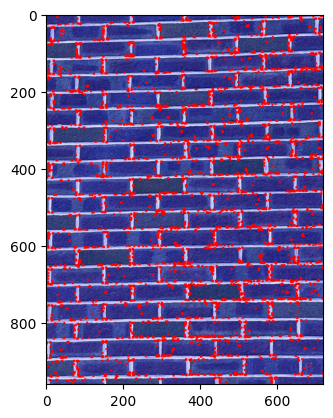

In [22]:
image = cv.imread("Brick/1.jpg")

plt.imshow(harris_corner_detection(image))

Match the features between images.

In [76]:
# Function match_features(image1, image2):
#     Detect keypoints and descriptors in image1 using SIFT
#     Detect keypoints and descriptors in image2 using SIFT
#     Match descriptors using brute-force matcher
#     Extract matched points from both images
#     Return matched points from image1 and image2

def match_features(image1, image2, grayed: bool = True):
    if grayed == False:
        image1, image2 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY), cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
        # image1, image2 = np.float32(image1), np.float32(image2)

    detect: cv.SIFT = cv.SIFT.create()

    kp1, ds1 = detect.detectAndCompute(image1, None)
    kp2, ds2 = detect.detectAndCompute(image2, None)

    matcher: cv.BFMatcher = cv.BFMatcher.create()
    matches = matcher.knnMatch(ds1, ds2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
    
    img = cv.drawMatchesKnn(image1, kp1, image2, kp2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    lst1, lst2 = [], []

    # For each match, export the point coordinates.
    for mat in matches:
        # print(mat)
        img1_idx = mat[0].queryIdx
        img2_idx = mat[1].trainIdx

        # print(kp1[img1_idx].pt)
        lst1.append(kp1[img1_idx])
        # print(kp2[img2_idx].pt)
        lst2.append(kp2[img2_idx])

    return good, img, lst1, lst2


# img1 = cv.imread("Latin Student Center/1.jpg", cv.IMREAD_GRAYSCALE)
# img2 = cv.imread("Latin Student Center/2.jpg", cv.IMREAD_GRAYSCALE)

# matches, img, lst1, lst2 = match_features(img1, img2)

# plt.imshow(img)

Create mosaic image.

In [77]:
# Create Mosaic:
#     Function create_mosaic(images, camera_matrix, dist_coeffs):
#         Undistort all images using undistort_image function
#         Initialize mosaic with the first undistorted image
#         For each subsequent undistorted image:
#             Detect Harris corners in both mosaic and current image using harris_corner_detection
#             Match features between mosaic and current image using match_features
#             Estimate homography using matched points
#             Warp mosaic image using the estimated homography
#             Blend current image into mosaic
#         Return final mosaic image

def create_mosaic(images, camera_matrix, dist_coeffs):
    mosaic_image = images[0]

    isFirst: bool = True
    for image in images:
        if isFirst:
            isFirst = False
            continue

        mosaic_image = harris_corner_detection(mosaic_image)
        image = harris_corner_detection(image)

        match, img, lst1, lst2 = match_features(mosaic_image, image)

        H = cv.findHomography(lst1, lst2, cv.RANSAC)
        out = cv.warpPerspective(mosaic_image, H)

        print(H)


image1 = cv.imread("Brick/1.jpg") # , cv.IMREAD_GRAYSCALE)
image2 = cv.imread("Brick/2.jpg") # , cv.IMREAD_GRAYSCALE)

# match, img = match_features(image1, image2)

create_mosaic([image1, image2], 0, 0)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'findHomography'
> Overload resolution failed:
>  - srcPoints is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'srcPoints'
>  - srcPoints is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'srcPoints'
